In [16]:
import pandas as pd
import numpy as np
import os
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import Callback
from keras.layers import Dense
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from keras.metrics import mean_absolute_percentage_error

In [2]:
from data_reader import z_score_inv

In [52]:
from next_batch import LSTM_WINDOW_SIZE, INPUT_SIZE, PREDICTORS
from next_batch import get_trainable_data

In [4]:
import os
os.environ['HOME']

'/Users/lijinyang'

In [5]:
plt.ion()

DATA_FILE = 'data.npz'
if not os.path.exists(DATA_FILE):
    (x_train, y_train), (x_test, y_test), mean, std = get_trainable_data()
    np.savez_compressed('data.npz', x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test,
                        mean=mean, std=std)
else:
    d = np.load(DATA_FILE)
    x_train = d['x_train']
    y_train = d['y_train']
    x_test = d['x_test']
    y_test = d['y_test']
    mean = d['mean']
    std = d['std']

print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)

print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)

x_train.shape = (2122, 10, 29)
y_train.shape = (2122, 1)
x_test.shape = (616, 10, 29)
y_test.shape = (616, 1)


In [53]:
PREDICTORS = PREDICTORS[:7]

In [54]:
PREDICTORS

['sigma',
 'returns',
 'Trend COMPUT',
 'Trend CRCARD',
 'Trend INVEST',
 'Trend BNKRPT',
 'Trend AIRTVL']

In [55]:
def print_np_arr(x):
    return np.array_repr(x).replace('\n', '')


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


class Monitor(Callback):

    def __init__(self, inputs):
        self.inputs = inputs

    def on_epoch_end(self, epoch, logs=None):
        np.set_printoptions(precision=6, suppress=True)

        # print('\n\n')
        # print('_' * 80)

        # TODO: make it with pandas and better.
        predictions = self.model.predict(self.inputs)
        # TODO: should be the mean_sigma of std_sigma only
        pred_sigmas = [z_score_inv(pred, mean, std) for pred in predictions.flatten()]
        true_sigmas = [z_score_inv(true, mean, std) for true in y_test.flatten()]
        dummy_sigmas = [z_score_inv(dummy, mean, std) for dummy in np.roll(y_test.flatten(), shift=1)]

        #if 'DISPLAY' not in os.environ:
        #    plt.clf()
        #    plt.plot(true_sigmas, color='blue')
        #    plt.plot(pred_sigmas, color='lime')
        #    plt.pause(0.001)
        #    plt.show()

        test_mape = mean_absolute_percentage_error(np.array(true_sigmas), np.array(pred_sigmas))
        dummy_mape = mean_absolute_percentage_error(np.array(true_sigmas), np.array(dummy_sigmas))
        print('[{0}] test = {1:.3f}, test_dummy = {2:.3f}, '
              'train = {3:.3f}, val = {4:.3f}.'.format(str(epoch).zfill(4), test_mape, dummy_mape,
                                                       logs['loss'], logs['val_loss']))
        
        logs['MAPE']=test_mape
        # num_values_to_predict = 10
        # r_train_idx = randint(a=0, b=len(x_train) - num_values_to_predict)
        # print('pred train  =',
        #       print_np_arr(self.model.predict(x_train[r_train_idx:r_train_idx + num_values_to_predict]).flatten()))
        # print('truth train =', print_np_arr(y_train[r_train_idx:r_train_idx + num_values_to_predict].flatten()))
        # r_test_idx = randint(a=0, b=len(x_test) - num_values_to_predict)
        # print('pred  test  =',
        #       print_np_arr(self.model.predict(x_test[r_test_idx:r_test_idx + num_values_to_predict]).flatten()))
        # print('truth test  =', print_np_arr(y_test[r_test_idx:r_test_idx + num_values_to_predict].flatten()))
        # print('_' * 80)
        # print('\n')


m = Sequential()
m.add(LSTM(32, input_shape=(LSTM_WINDOW_SIZE, INPUT_SIZE)))
# m.add(Dropout(0.1))
m.add(Dense(16, activation='sigmoid'))
# m.add(Dropout(0.1))
m.add(Dense(1, activation='linear'))


# PAPER: with mean absolute percent error (MAPE) as the objective loss function
# PAPER: The model is trained by the 'Adam' method

def sigma_loss(y_true, y_pred):
    real_y_true = y_true * std + mean
    real_y_pred = y_pred * std + mean
    return K.mean(K.abs(real_y_true - real_y_pred) / real_y_true) * 100


m.compile(optimizer=Adam(lr=0.0001), loss=sigma_loss)  # mape
m.summary()

for until_predictor_id in range(6, len(PREDICTORS)):

    try:
        print('Now we have {}/{} predictors.'.format(until_predictor_id + 1, len(PREDICTORS)))
        mask_train = np.zeros_like(x_train)
        mask_test = np.zeros_like(x_test)

        mask_train[:, :, 0:until_predictor_id + 1] = 1.0
        mask_test[:, :, 0:until_predictor_id + 1] = 1.0

        x_train_masked = x_train * mask_train
        x_test_masked = x_test * mask_test

        # PAPER: with 32 examples in a batch
        # PAPER:  This can be achieved after roughly 600 epochs.
        monitor = Monitor(inputs=x_test_masked)
        model = m.fit(x_train_masked, y_train,
                      validation_split=0.2,
                      shuffle=True,
                      batch_size=32,
                      epochs=600,
                      verbose=0,
                      callbacks=[monitor])

        # print('Learning rate was {}'.format(K.get_value(m.optimizer.lr)))
        # K.set_value(m.optimizer.lr, K.get_value(m.optimizer.lr) * 0.5)
        # print('Learning rate is now {}'.format(K.get_value(m.optimizer.lr)))

    except KeyboardInterrupt:
        print('Received KeyboardInterrupt. Going to add the next predictor.')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 32)                7936      
_________________________________________________________________
dense_43 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 17        
Total params: 8,481.0
Trainable params: 8,481
Non-trainable params: 0.0
_________________________________________________________________
Now we have 7/7 predictors.
[0000] test = 2343.180, test_dummy = 35.730, train = 861.210, val = 2075.512.
[0001] test = 2263.382, test_dummy = 35.730, train = 809.385, val = 1983.030.
[0002] test = 2177.576, test_dummy = 35.730, train = 756.846, val = 1893.391.
[0003] test = 2090.508, test_dummy = 35.730, train = 706.988, val = 1787.361.
[0004] test = 2004.567, test_dummy = 35.730, train = 656.426

[0100] test = 565.531, test_dummy = 35.730, train = 35.587, val = 64.705.
[0101] test = 559.302, test_dummy = 35.730, train = 35.689, val = 63.282.
[0102] test = 554.242, test_dummy = 35.730, train = 35.489, val = 63.739.
[0103] test = 556.072, test_dummy = 35.730, train = 35.520, val = 65.470.
[0104] test = 542.980, test_dummy = 35.730, train = 35.569, val = 62.081.
[0105] test = 544.706, test_dummy = 35.730, train = 35.585, val = 63.139.
[0106] test = 524.645, test_dummy = 35.730, train = 35.372, val = 56.907.
[0107] test = 529.388, test_dummy = 35.730, train = 35.350, val = 60.065.
[0108] test = 521.969, test_dummy = 35.730, train = 35.244, val = 58.920.
[0109] test = 525.301, test_dummy = 35.730, train = 35.354, val = 59.353.
[0110] test = 523.398, test_dummy = 35.730, train = 35.506, val = 58.546.
[0111] test = 520.718, test_dummy = 35.730, train = 35.341, val = 59.400.
[0112] test = 512.583, test_dummy = 35.730, train = 35.278, val = 57.374.
[0113] test = 517.995, test_dummy = 35

[0211] test = 380.968, test_dummy = 35.730, train = 32.838, val = 51.977.
[0212] test = 382.078, test_dummy = 35.730, train = 32.901, val = 52.492.
[0213] test = 398.861, test_dummy = 35.730, train = 33.074, val = 58.675.
[0214] test = 395.411, test_dummy = 35.730, train = 33.087, val = 57.598.
[0215] test = 389.733, test_dummy = 35.730, train = 32.831, val = 54.683.
[0216] test = 398.626, test_dummy = 35.730, train = 33.090, val = 57.325.
[0217] test = 394.943, test_dummy = 35.730, train = 32.793, val = 56.498.
[0218] test = 376.140, test_dummy = 35.730, train = 32.821, val = 50.847.
[0219] test = 376.723, test_dummy = 35.730, train = 32.802, val = 51.434.
[0220] test = 393.714, test_dummy = 35.730, train = 32.989, val = 57.859.
[0221] test = 386.159, test_dummy = 35.730, train = 32.736, val = 53.498.
[0222] test = 390.901, test_dummy = 35.730, train = 32.649, val = 53.561.
[0223] test = 404.388, test_dummy = 35.730, train = 32.782, val = 57.633.
[0224] test = 405.413, test_dummy = 35

[0322] test = 399.834, test_dummy = 35.730, train = 31.248, val = 59.638.
[0323] test = 400.787, test_dummy = 35.730, train = 31.241, val = 60.264.
[0324] test = 393.807, test_dummy = 35.730, train = 31.259, val = 58.522.
[0325] test = 391.926, test_dummy = 35.730, train = 31.442, val = 57.761.
[0326] test = 380.189, test_dummy = 35.730, train = 31.572, val = 53.981.
[0327] test = 387.760, test_dummy = 35.730, train = 31.123, val = 56.307.
[0328] test = 385.194, test_dummy = 35.730, train = 31.357, val = 53.377.
[0329] test = 388.367, test_dummy = 35.730, train = 31.178, val = 54.172.
[0330] test = 395.986, test_dummy = 35.730, train = 31.147, val = 57.612.
[0331] test = 386.870, test_dummy = 35.730, train = 31.175, val = 56.215.
[0332] test = 380.686, test_dummy = 35.730, train = 31.527, val = 53.461.
[0333] test = 394.227, test_dummy = 35.730, train = 31.051, val = 58.522.
[0334] test = 370.791, test_dummy = 35.730, train = 31.182, val = 49.879.
[0335] test = 389.076, test_dummy = 35

[0433] test = 375.138, test_dummy = 35.730, train = 30.043, val = 52.497.
[0434] test = 380.798, test_dummy = 35.730, train = 30.123, val = 54.448.
[0435] test = 392.069, test_dummy = 35.730, train = 30.166, val = 60.604.
[0436] test = 378.439, test_dummy = 35.730, train = 30.352, val = 54.420.
[0437] test = 375.744, test_dummy = 35.730, train = 30.383, val = 53.743.
[0438] test = 374.993, test_dummy = 35.730, train = 30.214, val = 53.888.
[0439] test = 377.321, test_dummy = 35.730, train = 29.989, val = 54.727.
[0440] test = 360.602, test_dummy = 35.730, train = 30.305, val = 50.127.
[0441] test = 386.569, test_dummy = 35.730, train = 30.108, val = 58.735.
[0442] test = 388.276, test_dummy = 35.730, train = 29.927, val = 58.302.
[0443] test = 382.797, test_dummy = 35.730, train = 30.498, val = 56.336.
[0444] test = 371.825, test_dummy = 35.730, train = 30.214, val = 52.254.
[0445] test = 390.286, test_dummy = 35.730, train = 30.156, val = 59.352.
[0446] test = 383.329, test_dummy = 35

[0544] test = 378.023, test_dummy = 35.730, train = 29.202, val = 56.511.
[0545] test = 367.745, test_dummy = 35.730, train = 29.160, val = 52.574.
[0546] test = 378.094, test_dummy = 35.730, train = 29.162, val = 56.650.
[0547] test = 371.111, test_dummy = 35.730, train = 29.227, val = 54.411.
[0548] test = 365.160, test_dummy = 35.730, train = 29.083, val = 52.209.
[0549] test = 369.549, test_dummy = 35.730, train = 29.489, val = 53.692.
[0550] test = 370.718, test_dummy = 35.730, train = 29.101, val = 54.293.
[0551] test = 372.269, test_dummy = 35.730, train = 29.088, val = 54.877.
[0552] test = 371.256, test_dummy = 35.730, train = 29.206, val = 53.719.
[0553] test = 382.252, test_dummy = 35.730, train = 29.178, val = 61.244.
[0554] test = 372.386, test_dummy = 35.730, train = 29.199, val = 56.124.
[0555] test = 369.879, test_dummy = 35.730, train = 28.999, val = 54.039.
[0556] test = 373.163, test_dummy = 35.730, train = 28.990, val = 55.084.
[0557] test = 373.139, test_dummy = 35

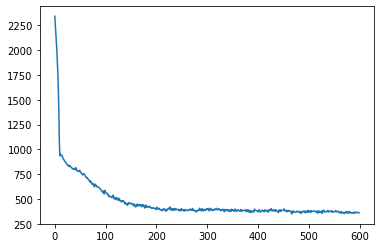

In [56]:
plt.plot(model.history['MAPE'])